## Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from cryptography.cnn_ipfe import IPFE

In [2]:
base_model = 1
model_path = f"models/cnn_model_{base_model}.pth"

In the First layer we applied 16 filters of size 3x3, with input channel 1 (grayscale), so the total number of parameters is 16 * 3 * 3 * 1 = 144.

So With that each y is one filter flattened to a vector of length 9.
For an input x of size 28x28, flattened to a vector of length 784, we can compute the inner product <x, y> for each filter y.

Option 1 encrypt the entire input x of length 784, and padd the y to a length of 784 with zeros. -> This will be inefficient as the IPFE scheme will have to handle large vectors.

Option 2 encrypt patches of x corresponding to the filter size (3x3 = 9 elements), and compute the inner product for each patch with the filter y. This requires sliding the filter over the input image and encrypting each patch separately.

1. Step: Create patches of size 3x3 from the input image (28x28) -> This will create 28x28 patches (with padding). => 784 patches
2. Step: Encrypt each patch separately.
3. Step: Create 16 query vectors y (one for each filter), each of size 9 (3x3 flattened). => Create a Key for each vector
4. Step: decrypt each inner product result to get the convolution output.

## Define Model

In [3]:
class IPFECNN(nn.Module):
    def __init__(self, num_classes=10, prime=1000000007):
        super(IPFECNN, self).__init__()
        self.prime = prime
        self.ipfe = IPFE(prime)
        self.encryption_length = 9 # 3x3 filter size flattened

        self.ipfe.setup(self.encryption_length)
        print("IPFE setup done, with length:", self.encryption_length)

        # First convolutional block - this will be used with IPFE
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

        #copy weights from the trained model
        self.load_state_dict(torch.load(model_path, map_location=device))
        print("weights copied from trained model")

        self.weights = self.conv1.weight.data
        self.y_array = torch.round(self.weights.view(self.weights.size(0), -1).squeeze(1).view(self.weights.size(0), -1) * 10000).long().tolist()
        print("weights converted to y vectors")
        self.biases = self.conv1.bias
        print("biases saved")
        self.sk_y_array = [self.ipfe.key_derive(y) for y in self.y_array]
        print("sk_ys created")

    def first_conv_forward(self, x, encrypted=False):
        if encrypted:
            batch_size = x.shape[0]
            H, W = x.shape[2], x.shape[3]

            unfold = nn.Unfold(kernel_size=3, stride=1, padding=1)
            patches = unfold(x)

            num_patches = patches.shape[-1]
            num_kernels = len(self.sk_y_array)

            feature_maps_batch = []

            for b in range(batch_size):
                patches_b = patches[b].T
                decrypted_maps = torch.zeros(num_kernels, num_patches, device=x.device)

                # Loop over patches and kernels
                for p in range(num_patches):
                    patch = patches_b[p]
                    patch_int = [(int(val.item()) % (self.prime - 1)) for val in patch]
                    encrypted_image = self.ipfe.encrypt(patch_int)

                    for k in range(num_kernels):
                        decrypted_scaled = self.ipfe.decrypt(encrypted_image, self.sk_y_array[k], self.y_array[k])

                        decrypted = (decrypted_scaled / 10000) + self.biases[k].item() # bias needed W*X + B
                        # (x1*y1*10000 + x2*y2*10000 + x3*y3*10000)/10000 = (x1*y1 + x2*y2 + x3*y3)

                        decrypted_maps[k, p] = decrypted

                # Reshape to feature map: (num_kernels, H, W)
                feature_maps_b = decrypted_maps.view(num_kernels, H, W)
                feature_maps_batch.append(feature_maps_b)

            x_ipfe = torch.stack(feature_maps_batch, dim=0)  # (B, num_kernels, H, W)
            return x_ipfe

        else:
            return self.conv1(x)

    def forward(self, x, encrypted=False):

        x = self.first_conv_forward(x, encrypted)
        x = self.pool1(F.relu(self.bn1(x)))

        # use regular forward pass for remaining layers
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


## Initialize Model

In [4]:
# Initialize IPFE-enhanced CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ipfe_model = IPFECNN(num_classes=10, prime=1000000007).to(device)

print(f"IPFE-CNN model created on device: {device}")

IPFE setup done, with length: 9
weights copied from trained model
weights converted to y vectors
biases saved
sk_ys created
IPFE-CNN model created on device: cpu


## Load Data

In [6]:
transform = transforms.Compose([
    transforms.Lambda(lambda pic: torch.tensor(np.array(pic), dtype=torch.float32).unsqueeze(0))
])
batch_size = 64
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Test samples: {len(test_dataset)}")

Test samples: 10000


## Test model

In [7]:
# Test IPFE functionality with a sample
def test_ipfe_cnn(model, test_loader, device, num_samples=5):
    """Test the IPFE-CNN with a sample query vector"""
    model.eval()
    # x is 784 big

    with torch.no_grad():
        # Get a batch of test data
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)
        print(f"Labels of test samples: {labels[:num_samples].cpu().numpy()}")

        # Test regular forward pass
        print("Testing regular forward pass...")
        regular_outputs = model(images[:num_samples])
        _, regular_predicted = regular_outputs.max(1)
        print("Regular predictions:", regular_predicted.cpu().numpy())

        # Test IPFE forward pass
        print("Testing IPFE forward pass...")
        try:
            ipfe_outputs = model.forward(images[:num_samples], encrypted=True)
            _, ipfe_predicted = ipfe_outputs.max(1)

            print(f"IPFE predictions: {ipfe_predicted.cpu().numpy()}")

            # Compare results
            matches = (regular_predicted == ipfe_predicted).sum().item()
            print(f"Prediction matches between regular and IPFE: {matches}/{num_samples}")

        except Exception as e:
            print(f"IPFE forward pass failed: {e}")

# Test the IPFE functionality
print("Testing IPFE-CNN functionality...")
test_ipfe_cnn(ipfe_model, test_loader, device)


Testing IPFE-CNN functionality...
Labels of test samples: [7 2 1 0 4]
Testing regular forward pass...
Regular predictions: [7 2 1 0 4]
Testing IPFE forward pass...
IPFE predictions: [7 2 1 0 4]
Prediction matches between regular and IPFE: 5/5


Visualizing first CNN layer filters...


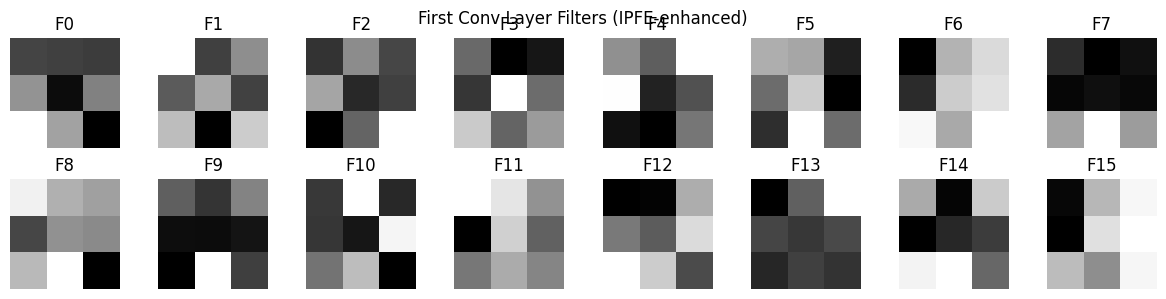

In [10]:
# Visualize the first CNN layer's filters (weights)
def visualize_first_cnn_layer(model):
    """Visualize the first convolutional layer filters"""
    # Find the first conv layer
    first_conv = None
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            first_conv = m
            break
    if first_conv is None:
        print("No Conv2d layer found in model.")
        return

    weights = first_conv.weight.data.cpu()
    num_filters = weights.shape[0]

    # Calculate grid size
    cols = 8
    rows = (num_filters + cols - 1) // cols

    plt.figure(figsize=(cols*1.5, rows*1.5))
    for i in range(num_filters):
        ax = plt.subplot(rows, cols, i+1)
        # For grayscale, show as [out_ch, in_ch, H, W]
        w = weights[i, 0].numpy()
        ax.imshow(w, cmap='gray')
        ax.axis('off')
        ax.set_title(f'F{i}')
    plt.tight_layout()
    plt.suptitle("First Conv Layer Filters (IPFE-enhanced)")
    plt.show()

print("Visualizing first CNN layer filters...")
visualize_first_cnn_layer(ipfe_model)
